## Setup

In [1]:
import MEArec as mr
import numpy as np
import scipy.optimize
import os
import sys
import re
import ast
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from collections import defaultdict
from joblib import Parallel, delayed

import spikeinterface as si
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
import spikeinterface.comparison as scomp
import spikeinterface.curation as scu

sys.path.append('src')
from src.util_eval import *
from src.util_loc import *

In [2]:
# Overall parameters
mearec_seed = 46
dead_indices_seeds = [42, 43, 44, 45, 46]
run_id = f'20241226_{mearec_seed}'
sorter_name = 'mountainsort4'
days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
        'D10','D11','D12','D13','D14','D15','D16','D17','D18','D19',
        'D20','D21','D22','D23','D24']
methods = ['center_of_mass', 'monopolar_triangulation', 'grid_convolution']
stable_days = 1
dead_electrodes_per_day = 1
gt_toggle = 0 # if 0, use ground truth data as experimental data
correct_radius = 30 # microns

# MEArec parameters
mearec_probe = 'SqMEA-5-30'
num_channels = 25
recgen_duration = 600
mearec_noise_level = 1
output_mearec = f'output/{run_id}'

In [3]:
# Create the template and recording generator for multiple days

cell_folder = mr.get_default_cell_models_folder()
temp_params = mr.get_default_templates_params()
temp_params['n'] = 10  # Number of neurons
temp_params['probe'] = mearec_probe

for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
    output_mearec_seed = f'{output_mearec}/seed_{dead_indices_seed}'
    
    if os.path.exists(f'{output_mearec_seed}/templates.h5'):
        tempgen = mr.load_templates(f'{output_mearec_seed}/templates.h5')
        recgen = mr.load_recordings(f'{output_mearec_seed}/D0/recording.h5')
    
    else:
        temp_params['seed'] = mearec_seed
        tempgen = mr.gen_templates(cell_models_folder=cell_folder, params=temp_params, templates_tmp_folder=None, intraonly=False, 
                                   parallel=True, recompile=False, n_jobs=None, delete_tmp=True, verbose=False)
        mr.save_template_generator(tempgen, f'{output_mearec_seed}/templates.h5')
            
        for day_i, day in enumerate(days):
            rec_params = mr.get_default_recordings_params()
            rec_params['spiketrains']['duration'] = recgen_duration # Duration of recording in seconds
            rec_params['recordings']['fs'] = 30000 # Sampling frequency
            rec_params['recordings']['noise_level'] = mearec_noise_level
            rec_params['seeds']['templates'] = mearec_seed

            recgen = mr.gen_recordings(params=rec_params, tempgen=tempgen)
            mr.save_recording_generator(recgen, f'{output_mearec_seed}/{day}/recording.h5')

Setting n_jobs to 20 CPUs


Starting simulation 1/13 - cell: L5_BP_bAC217_1

Starting simulation 3/13 - cell: L5_ChC_cACint209_1

Starting simulation 5/13 - cell: L5_LBC_bAC217_1

Starting simulation 6/13 - cell: L5_MC_bAC217_1

Starting simulation 9/13 - cell: L5_SBC_bNAC219_1

Starting simulation 4/13 - cell: L5_DBC_bAC217_1

Starting simulation 2/13 - cell: L5_BTC_bAC217_1

Starting simulation 13/13 - cell: L5_UTPC_cADpyr232_1

Starting simulation 7/13 - cell: L5_NBC_bAC217_1

Starting simulation 12/13 - cell: L5_TTPC2_cADpyr232_1

Starting simulation 10/13 - cell: L5_STPC_cADpyr232_1

Starting simulation 8/13 - cell: L5_NGC_bNAC219_1

Starting simulation 11/13 - cell: L5_TTPC1_cADpyr232_1

Intracellular simulation: /home/hao-zhao/.config/mearec/1.9.1/cell_models/bbp/L5_BP_bAC217_1
Extracellular simulation: /home/hao-zhao/.config/mearec/1.9.1/cell_models/bbp/L5_BP_bAC217_1
Intracellular simulation: /home/hao-zhao/.config/mearec/1.9.1/cell_models/bbp/L5_ChC_cACint209_1
Extracellular simulation: /home/hao-zhao/.

In [4]:
# Function to process each seed
def process_seed(dead_indices_seed_i, dead_indices_seed):
    output_mearec_seed = f'{output_mearec}/seed_{dead_indices_seed}'
    
    # Dead indices
    if os.path.exists(f'{output_mearec_seed}/dead_indices.pkl'):
        print('Loading dead indices')
        with open(f'{output_mearec_seed}/dead_indices.pkl', 'rb') as f:
            dead_indices = pickle.load(f)
    else:
        print('Creating dead indices')
        np.random.seed(dead_indices_seed)
        
        dead_indices = []
        dead_indices_temp = np.random.choice(range(num_channels), size=dead_electrodes_per_day*(len(days)-stable_days), replace=False)
        for day_i, day in enumerate(days):
            if day_i < stable_days:
                dead_indices.append([])
            else:
                dead_indices.append(dead_indices_temp[:dead_electrodes_per_day*(day_i-1)])
        
        with open(f'{output_mearec_seed}/dead_indices.pkl', "wb") as file:
            pickle.dump(dead_indices, file)

    # Recording data
    recording_mearec = se.MEArecRecordingExtractor(f'{output_mearec_seed}/D0/recording.h5')
    probe = recording_mearec.get_probe()

    recordings = []
    for day_i, day in enumerate(days):
        
        if os.path.exists(f'{output_mearec_seed}/{day}/recording'):
            recordings.append(sc.load_extractor(f'{output_mearec_seed}/{day}/recording').set_probe(probe, in_place=True))
        else:
            recording_mearec = se.MEArecRecordingExtractor(f'{output_mearec_seed}/{day}/recording.h5')
            probe = recording_mearec.get_probe()
            get_recording_noise(recording_mearec, dead_indices[day_i], f'{output_mearec_seed}/{day}/recording')
            recordings.append(sc.load_extractor(f'{output_mearec_seed}/{day}/recording').set_probe(probe, in_place=True))

    recording = sc.concatenate_recordings(recordings).set_probe(probe, in_place=True)    
    
    # Sorting data
    sortings_gt = []
    for day_i, day in enumerate(days):
        sortings_gt.append(se.MEArecSortingExtractor(f'{output_mearec_seed}/{day}/recording.h5'))
    sorting_gt = sc.append_sortings(sortings_gt)        
    
    # Waveform extractor data
    wes_gt = []
    for day_i, day in enumerate(days):
        wes_gt.append(si.extract_waveforms(recordings[day_i], sortings_gt[day_i], folder=f'{output_mearec_seed}/{day}/waveforms_gt', ms_before=1, ms_after=2, load_if_exists=True))
        wes_gt[-1].run_extract_waveforms()

    # Calculate template locations
    if os.path.exists(f'{output_mearec_seed}/loc_est_units'):
        print('Loading template localization estimates')
        with open(f'{output_mearec_seed}/loc_est_units/loc_est_units.pkl', 'rb') as f:
            loc_est_units = pickle.load(f)
        with open(f'{output_mearec_seed}/loc_est_units/time_units.pkl', 'rb') as f:
            time_units = pickle.load(f)
            
    else:
        print('Calculating template localization estimates')            
        loc_est_units = {} # First entry is method. Then the entry is a list of locations across days.
        time_units = {}

        for method in methods:
            start_time = time.time()
            loc_est_units[method] = get_unit_loc_est(method, wes_gt)
            time_units[method] = time.time() - start_time
        
        os.makedirs(f'{output_mearec_seed}/loc_est_units')
        pickle.dump(loc_est_units, open(f'{output_mearec_seed}/loc_est_units/loc_est_units.pkl', 'wb'))
        pickle.dump(time_units, open(f'{output_mearec_seed}/loc_est_units/time_units.pkl', 'wb'))        

    # Calculate spike location estimates
    if os.path.exists(f'{output_mearec_seed}/loc_est_spikes'):
        print('Loading spike localization estimates')
        with open(f'{output_mearec_seed}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
            loc_est_spikes = pickle.load(f)
        with open(f'{output_mearec_seed}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
            time_spikes = pickle.load(f)

    else:
        print('Calculating spike localization estimates')
        loc_est_spikes = {} # First entry is method, second is day.
        time_spikes = {}

        for method in methods:
            
            loc_est_spikes[method] = {}
            time_spikes[method] = {}
            for day_i, day in enumerate(days):
                
                start_time = time.time()
                if method == 'monopolar_triangulation':
                    unit_loc_est = spost.compute_spike_locations(wes_gt[day_i], method=method, outputs='by_unit', method_kwargs={'optimizer': 'least_square'})
                else:
                    unit_loc_est = spost.compute_spike_locations(wes_gt[day_i], method=method, outputs='by_unit')
                time_spikes[method][day] = time.time() - start_time
                loc_est_spikes[method][day] = unit_loc_est
        
        os.makedirs(f'{output_mearec_seed}/loc_est_spikes')
        pickle.dump(loc_est_spikes, open(f'{output_mearec_seed}/loc_est_spikes/loc_est_spikes.pkl', 'wb'))
        pickle.dump(time_spikes, open(f'{output_mearec_seed}/loc_est_spikes/time_spikes.pkl', 'wb'))
    
    # Delete the day subfolders except first and all data inside
    if dead_indices_seed != 42:
        for day_i, day in enumerate(days[1:]):
            os.system(f'rm -r {output_mearec_seed}/{day}')

# Use joblib to parallelize the processing of seeds
Parallel(n_jobs=-1)(delayed(process_seed)(dead_indices_seed_i, dead_indices_seed) for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds))

Creating dead indices
Creating dead indices
Creating dead indices
Creating dead indices
Creating dead indices
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s].55it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:20<00:00, 29.43it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s].91it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:24<00:00, 24.34it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:28, 20.85it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:24<00:00, 24.53it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:25, 23.47it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:24<00:00, 24.79it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|1         | 9/600 [00:00<00:24, 23.84it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.39it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:30, 19.82it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   1%|1         | 8/600 [00:00<00:30, 19.65it/s]]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.32it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:24, 24.40it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:25, 23.06it/s]]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:28<00:00, 21.20it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:35, 16.90it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 14/600 [00:00<00:28, 20.90it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:27<00:00, 22.17it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s].81it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.62it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:32, 18.52it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:28<00:00, 20.84it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   1%|          | 4/600 [00:00<00:31, 18.90it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:29<00:00, 20.41it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:26, 22.46it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 15/600 [00:00<00:26, 22.28it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:27<00:00, 22.00it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:32, 18.45it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 15/600 [00:00<00:27, 21.66it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:28<00:00, 20.97it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:26, 22.79it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|1         | 9/600 [00:00<00:26, 22.16it/s]]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 12/600 [00:00<00:25, 23.17it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.50it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:32, 18.32it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 14/600 [00:00<00:28, 20.76it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 23.03it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:25, 23.22it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:34, 17.53it/s]]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.34it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|1         | 9/600 [00:00<00:25, 23.41it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:21<00:00, 27.95it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   1%|1         | 6/600 [00:00<00:26, 22.12it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:27<00:00, 21.91it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|1         | 9/600 [00:00<00:25, 22.84it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 15/600 [00:00<00:27, 21.47it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.26it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 2/600 [00:00<00:30, 19.63it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 12/600 [00:00<00:25, 23.25it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:27<00:00, 21.56it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|1         | 9/600 [00:00<00:23, 24.66it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 15/600 [00:00<00:25, 23.08it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:25<00:00, 23.15it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   1%|1         | 6/600 [00:00<00:27, 21.89it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:23<00:00, 25.03it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s].21it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|2         | 15/600 [00:00<00:24, 23.84it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:25<00:00, 23.38it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   2%|1         | 9/600 [00:00<00:24, 24.22it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:26, 22.46it/s]]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:28<00:00, 21.42it/s]


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 3/600 [00:00<00:26, 22.77it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s].60it/s]

write_binary_recording with n_jobs = 1 and chunk_size = 30000
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 600/600 [00:26<00:00, 22.63it/s]
/tmp/ipykernel_125406/4290734644.py:51: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer: 100%|##########| 600/600 [00:00<00:00, 2780.33it/s]


Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|5         | 35/600 [00:00<00:01, 340.76it/s]]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|5         | 32/600 [00:00<00:01, 314.75it/s]]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer: 100%|##########| 600/600 [00:00<00:00, 2522.40it/s]


Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  91%|#########1| 548/600 [00:00<00:00, 2694.87it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  30%|##9       | 177/600 [00:00<00:00, 442.75it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  80%|#######9  | 479/600 [00:01<00:00, 507.28it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  79%|#######9  | 475/600 [00:01<00:00, 377.42it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]445.55it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|5         | 30/600 [00:00<00:01, 298.92it/s]].49it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer: 100%|##########| 600/600 [00:01<00:00, 442.53it/s]


Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  79%|#######9  | 475/600 [00:01<00:00, 352.32it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  60%|######    | 363/600 [00:00<00:00, 415.88it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  84%|########4 | 507/600 [00:01<00:00, 474.13it/s].19it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  84%|########4 | 504/600 [00:00<00:00, 2114.10it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  59%|#####8    | 352/600 [00:00<00:00, 408.46it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  42%|####2     | 253/600 [00:00<00:00, 2526.04it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  96%|#########6| 578/600 [00:01<00:00, 408.52it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]24.10it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  81%|########1 | 486/600 [00:01<00:00, 402.26it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  91%|#########1| 547/600 [00:01<00:00, 478.57it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 36/600 [00:00<00:01, 357.41it/s]5.78it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  71%|#######   | 424/600 [00:01<00:00, 383.13it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  44%|####4     | 265/600 [00:00<00:00, 396.59it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  93%|#########3| 560/600 [00:00<00:00, 2619.50it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  34%|###3      | 201/600 [00:00<00:00, 426.96it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  19%|#8        | 112/600 [00:00<00:01, 385.87it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  25%|##4       | 149/600 [00:00<00:01, 376.10it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  31%|###1      | 188/600 [00:00<00:00, 423.71it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  37%|###7      | 223/600 [00:00<00:00, 2227.90it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 36/600 [00:00<00:01, 354.92it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  32%|###1      | 189/600 [00:00<00:01, 359.10it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  18%|#7        | 105/600 [00:00<00:01, 342.67it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  68%|######8   | 409/600 [00:00<00:00, 492.89it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   4%|4         | 24/600 [00:00<00:02, 235.61it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 37/600 [00:00<00:01, 365.52it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  57%|#####6    | 342/600 [00:00<00:00, 426.45it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  35%|###5      | 211/600 [00:00<00:00, 2103.99it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  18%|#8        | 110/600 [00:00<00:01, 381.76it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  46%|####6     | 278/600 [00:00<00:00, 394.25it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   4%|4         | 27/600 [00:00<00:02, 267.57it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|5         | 33/600 [00:00<00:01, 328.84it/s]]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  18%|#7        | 107/600 [00:00<00:01, 354.25it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  45%|####5     | 270/600 [00:00<00:00, 385.01it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  46%|####6     | 277/600 [00:00<00:00, 411.54it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   4%|4         | 25/600 [00:00<00:02, 237.65it/s]]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  67%|######7   | 403/600 [00:01<00:00, 368.67it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]405.11it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  56%|#####5    | 334/600 [00:00<00:00, 415.76it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer: 100%|##########| 600/600 [00:00<00:00, 2838.12it/s]


Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  86%|########6 | 519/600 [00:01<00:00, 428.74it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer: 100%|##########| 600/600 [00:00<00:00, 2813.47it/s]


Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  83%|########2 | 497/600 [00:01<00:00, 413.86it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|4         | 29/600 [00:00<00:01, 287.62it/s]]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|5         | 31/600 [00:00<00:01, 304.64it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 36/600 [00:00<00:01, 351.33it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  22%|##1       | 131/600 [00:00<00:01, 432.58it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  56%|#####6    | 336/600 [00:00<00:00, 503.58it/s].40it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]405.70it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 36/600 [00:00<00:01, 351.00it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  47%|####7     | 284/600 [00:00<00:00, 454.24it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|5         | 33/600 [00:00<00:01, 329.00it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  35%|###4      | 208/600 [00:00<00:00, 398.93it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  56%|#####6    | 337/600 [00:00<00:00, 452.98it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  34%|###3      | 203/600 [00:00<00:00, 2029.48it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  95%|#########5| 570/600 [00:01<00:00, 309.49it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  50%|#####     | 300/600 [00:01<00:00, 338.95it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|5         | 32/600 [00:00<00:01, 317.66it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  47%|####7     | 283/600 [00:00<00:00, 368.35it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  89%|########9 | 535/600 [00:01<00:00, 423.33it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  86%|########5 | 513/600 [00:01<00:00, 375.10it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 36/600 [00:00<00:01, 358.96it/s]]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  79%|#######9  | 476/600 [00:00<00:00, 1831.65it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  75%|#######5  | 452/600 [00:01<00:00, 415.79it/s].73it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|6         | 39/600 [00:00<00:01, 388.20it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|4         | 29/600 [00:00<00:01, 287.74it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  64%|######3   | 381/600 [00:00<00:00, 428.15it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:  86%|########6 | 517/600 [00:00<00:00, 2363.75it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  98%|#########7| 585/600 [00:01<00:00, 351.02it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   6%|5         | 35/600 [00:00<00:01, 346.72it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   7%|6         | 41/600 [00:00<00:01, 406.67it/s]9.54it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  22%|##1       | 131/600 [00:00<00:01, 386.47it/s].88it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   5%|5         | 30/600 [00:00<00:01, 299.50it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  74%|#######3  | 441/600 [00:01<00:00, 394.37it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]340.64it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer: 100%|##########| 600/600 [00:00<00:00, 2705.32it/s]


Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  14%|#3        | 83/600 [00:00<00:01, 404.71it/s]]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s] ?it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]440.35it/s]

Setting 'return_scaled' to False
Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]35.51it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:  60%|#####9    | 359/600 [00:00<00:00, 389.48it/s]

Calculating template localization estimates


extract waveforms memmap multi buffer:  82%|########1 | 491/600 [00:01<00:00, 400.73it/s]

Calculating template localization estimates


extract waveforms memmap multi buffer: 100%|##########| 600/600 [00:01<00:00, 405.72it/s]


Calculating template localization estimates
Calculating template localization estimates


extract waveforms memmap multi buffer: 100%|##########| 600/600 [00:01<00:00, 410.42it/s]


Calculating template localization estimates
Calculating spike localization estimates


localize peaks using center_of_mass:   2%|2         | 14/600 [00:00<00:04, 134.70it/s]

Calculating spike localization estimates


localize peaks using center_of_mass:   7%|7         | 43/600 [00:00<00:04, 125.16it/s]

Calculating spike localization estimates


localize peaks using center_of_mass:  36%|###5      | 214/600 [00:01<00:02, 149.94it/s]

Calculating spike localization estimates


localize peaks using center_of_mass:  83%|########3 | 500/600 [00:03<00:00, 139.38it/s]

Calculating spike localization estimates


extract waveforms shared_memory mono buffer: 100%|##########| 600/600 [00:00<00:00, 3096.84it/s]
/home/hao-zhao/anaconda3/envs/haozhao-si-0.100/lib/python3.8/site-packages/spikeinterface/sortingcomponents/tools.py:80: RuntimeWarning: divide by zero encountered in true_divide
  prototype = np.nanmedian(waveforms[:, :, 0] / (np.abs(waveforms[:, nbefore, 0][:, np.newaxis])), axis=0)
/home/hao-zhao/anaconda3/envs/haozhao-si-0.100/lib/python3.8/site-packages/spikeinterface/sortingcomponents/tools.py:80: RuntimeWarning: invalid value encountered in true_divide
  prototype = np.nanmedian(waveforms[:, :, 0] / (np.abs(waveforms[:, nbefore, 0][:, np.newaxis])), axis=0)
extract waveforms shared_memory mono buffer: 100%|##########| 600/600 [00:00<00:00, 3447.14it/s]
/home/hao-zhao/anaconda3/envs/haozhao-si-0.100/lib/python3.8/site-packages/spikeinterface/sortingcomponents/tools.py:80: RuntimeWarning: divide by zero encountered in true_divide
  prototype = np.nanmedian(waveforms[:, :, 0] / (np.abs(

[None, None, None, None, None]

## Figure Charts - Individual Seed

In [4]:
# Recording data
recording_mearec = se.MEArecRecordingExtractor(f'{output_mearec}/seed_42/D0/recording.h5')
probe = recording_mearec.get_probe()

recordings = []
for day_i, day in enumerate(days):    
    recordings.append(sc.load_extractor(f'{output_mearec}/seed_42/{day}/recording').set_probe(probe, in_place=True))

# Sorting data
sortings_gt = []
for day_i, day in enumerate(days):
    sortings_gt.append(se.MEArecSortingExtractor(f'{output_mearec}/seed_42/{day}/recording.h5'))
sorting_gt = sc.append_sortings(sortings_gt)        

# Waveform extractor data
wes_gt = []
for day_i, day in enumerate(days):
    wes_gt.append(si.extract_waveforms(recordings[day_i], sortings_gt[day_i], folder=f'{output_mearec}/seed_42/{day}/waveforms_gt', ms_before=1, ms_after=2, load_if_exists=True))
    wes_gt[-1].run_extract_waveforms()

electrode_loc = recordings[0].get_channel_locations()
unit_loc_true = recgen.template_locations

dead_indices_coll = []
tempgen_coll = []
recgen_coll = []
loc_est_units_coll = []
time_units_coll = []
loc_est_spikes_coll = []
time_spikes_coll = []

for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
    output_mearec_seed = f'{output_mearec}/seed_{dead_indices_seed}'
    
    # Dead indices
    with open(f'{output_mearec_seed}/dead_indices.pkl', 'rb') as f:
        dead_indices_coll.append(pickle.load(f))

    # Load tempgen and recgen
    tempgen_coll.append(mr.load_templates(f'{output_mearec_seed}/templates.h5'))
    recgen_coll.append(mr.load_recordings(f'{output_mearec_seed}/D0/recording.h5'))

    # Load templates
    with open(f'{output_mearec_seed}/loc_est_units/loc_est_units.pkl', 'rb') as f:
        loc_est_units_coll.append(pickle.load(f))
    with open(f'{output_mearec_seed}/loc_est_units/time_units.pkl', 'rb') as f:
        time_units_coll.append(pickle.load(f))

    # Load spikes
    with open(f'{output_mearec_seed}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
        loc_est_spikes_coll.append(pickle.load(f))
    with open(f'{output_mearec_seed}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
        time_spikes_coll.append(pickle.load(f))

/tmp/ipykernel_112670/268514487.py:18: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  wes_gt.append(si.extract_waveforms(recordings[day_i], sortings_gt[day_i], folder=f'{output_mearec}/seed_42/{day}/waveforms_gt', ms_before=1, ms_after=2, load_if_exists=True))


extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

In [6]:
fig_days = ['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'D16', 'D18', 'D20', 'D22', 'D24']

fig_days_label = []
for day_i in range(len(fig_days)):
    fig_days_label.append(dead_electrodes_per_day*days.index(fig_days[day_i])/num_channels)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig_method_label = ['CoM', 'MT', 'GC']

[0.84, 0.92, 0.88]


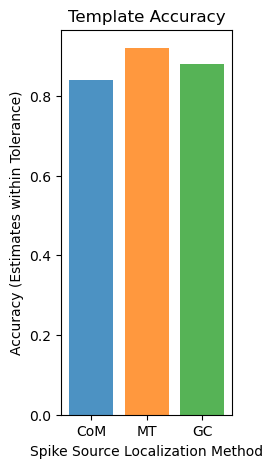

In [7]:
"""Figure 2: Template Accuracy with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method_i, method in enumerate(methods):
    we_i = 0
    we = wes_gt[0]
    
    n_right = 0
    n_wrong = 0
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        unit_loc_est = loc_est_units[method]
        for unit_idx, unit_id in enumerate(we.unit_ids):
            if np.linalg.norm(unit_loc_est[we_i][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                n_right += 1
            else:
                n_wrong += 1
        
    loss.append(n_right / (n_right + n_wrong))


# Create plot
print(loss)

ax.bar(fig_method_label, loss, color=colors, alpha=0.8)
ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
fig.savefig(f'{output_mearec}/2A_1.png', format='png', bbox_inches='tight')

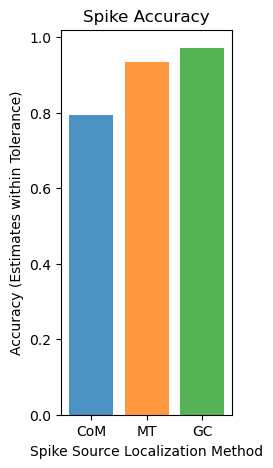

In [8]:
"""Figure 2: Spike Accuracy with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    we_i = 0
    we = wes_gt[0]
    
    n_right = 0
    n_wrong = 0
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        unit_loc_est = loc_est_spikes[method][days[we_i]]

        # Calculate loss
        for unit_idx, unit_id in enumerate(we.unit_ids):
            unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
            n_right += unit_n_right
            n_wrong += unit_n_wrong

    loss.append(n_right / (n_right + n_wrong))

ax.bar(['CoM','MT','GC'], loss, color=colors, alpha=0.8)
ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
fig.savefig(f'{output_mearec}/2B_1.png', format='png', bbox_inches='tight')

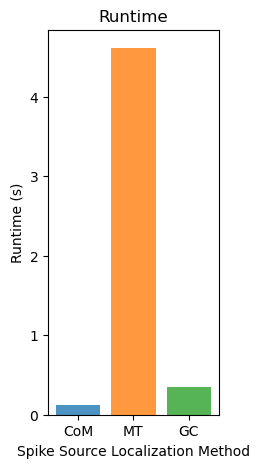

In [9]:
"""Figure 2: Template Runtime with No Dead Electrodes"""

fig_time = np.zeros(len(methods))
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))
for method_i, method in enumerate(methods):

    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        fig_time[method_i] += (time_units[method] / len(dead_indices_seeds))

ax.bar(fig_method_label, fig_time, color=colors, alpha=0.8)
ax.title.set_text(f'Runtime')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Runtime (s)')
fig.savefig(f'{output_mearec}/2A_2.png', format='png', bbox_inches='tight')

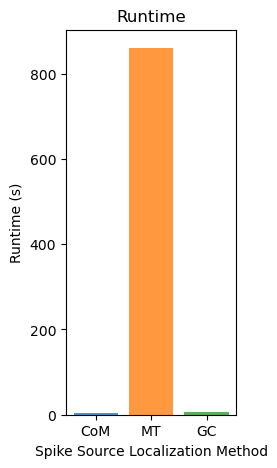

In [10]:
"""Figure 2: Spike Runtime with No Dead Electrodes"""

fig_time = np.zeros(len(methods))
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))
for method_i, method in enumerate(methods):

    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        fig_time[method_i] += (time_spikes[method][days[0]] / len(dead_indices_seeds))

ax.bar(fig_method_label, fig_time, color=colors, alpha=0.8)
ax.title.set_text(f'Runtime')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Runtime (s)')
fig.savefig(f'{output_mearec}/2B_2.png', format='png', bbox_inches='tight')

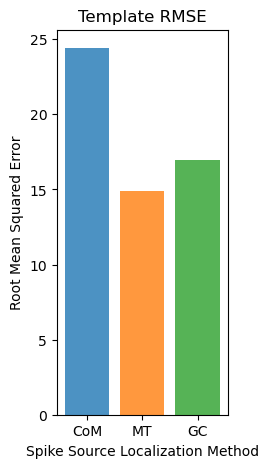

In [11]:
"""Figure 2: Template RMSE with No Dead Electrodes"""

loss = np.zeros(len(methods))
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method_i, method in enumerate(methods):

    we_i = 0
    we = wes_gt[0]

    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        unit_loc_est = loc_est_units[method]
        loss[method_i] += get_loss_rmse_gt(unit_loc_true, unit_loc_est[we_i]) / len(dead_indices_seeds)

ax.bar(['CoM','MT','GC'], loss, color=colors, alpha=0.8)
ax.title.set_text(f'Template RMSE')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Root Mean Squared Error')
fig.savefig(f'{output_mearec}/2A_3.png', format='png', bbox_inches='tight')

[24.22271725415297, 19.297503319960096, 17.016627514631615]


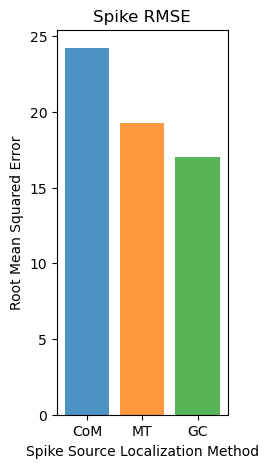

In [12]:
"""Figure 2: Spike RMSE with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method in methods:

    we_i = 0
    we = wes_gt[0]
    
    day_SE = 0
    day_spikes = 0
    unit_loc_est = loc_est_spikes[method][days[we_i]]
    
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]
            
        # Calculate loss
        for unit_idx, unit_id in enumerate(we.unit_ids):                
            unit_SE, unit_spikes = get_loss_RMSE_spikes_2(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
            day_SE += unit_SE
            day_spikes += unit_spikes
    
    loss.append(np.sqrt(day_SE/day_spikes))

print(loss)

ax.bar(['CoM','MT','GC'], loss, color=colors, alpha=0.8)
ax.title.set_text(f'Spike RMSE')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Root Mean Squared Error')
fig.savefig(f'{output_mearec}/2B_3.png', format='png', bbox_inches='tight')

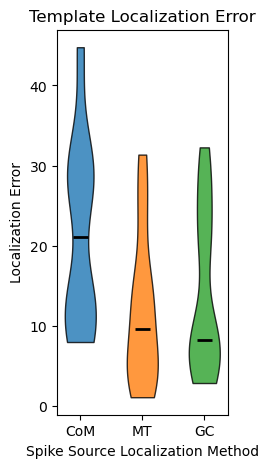

In [13]:
"""Figure 2: Template RMSE Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method_i, method in enumerate(methods):

    we_i = 0
    we = wes_gt[0]

    rmse = []
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        unit_loc_est = loc_est_units[method]
        diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
        rmse.extend(np.sqrt(np.sum(diff**2, axis=1)))
    
    loss.append(rmse)

# Create the violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize the violin plot to resemble seaborn's default style
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Adding the median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['CoM', 'MT', 'GC'])

ax.title.set_text('Template Localization Error')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Localization Error')

fig.savefig(f'{output_mearec}/2A_4.png', format='png', bbox_inches='tight')

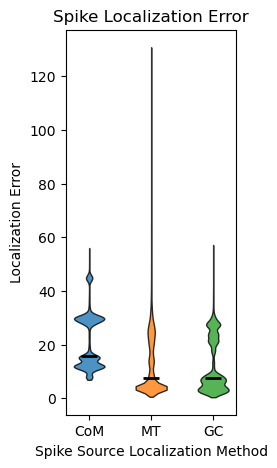

In [14]:
"""Figure 2: Spike RMSE Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method in methods:

    we_i = 0
    we = wes_gt[0]
    
    day_err = []
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        unit_loc_est = loc_est_spikes[method][days[we_i]]
        
        # Calculate loss
        for unit_idx, unit_id in enumerate(we.unit_ids):                
            unit_err = get_loss_RMSE_spikes_ind(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
            day_err.extend(unit_err)
        
    day_err.sort()
    day_err = day_err[220:-220]
    loss.append(day_err)

# Create the violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize the violin plot to resemble seaborn's default style
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Adding the median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['CoM', 'MT', 'GC'])

ax.title.set_text('Spike Localization Error')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Localization Error')

fig.savefig(f'{output_mearec}/2B_4.png', format='png', bbox_inches='tight')

NameError: name 'wes_gt' is not defined

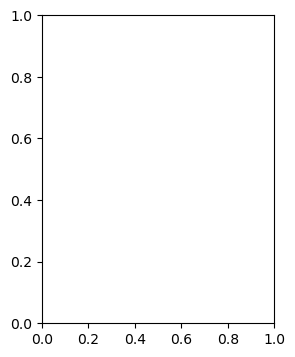

In [5]:
"""Figure 3A: Template Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss = []
    for we_i, we in enumerate(wes_gt):

        if days[we_i] in fig_days:

            n_right = 0
            n_wrong = 0
            for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                dead_indices = dead_indices_coll[dead_indices_seed_i]
                tempgen = tempgen_coll[dead_indices_seed_i]
                recgen = recgen_coll[dead_indices_seed_i]
                loc_est_units = loc_est_units_coll[dead_indices_seed_i]
                time_units = time_units_coll[dead_indices_seed_i]
                loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
                time_spikes = time_spikes_coll[dead_indices_seed_i]

                unit_loc_est = loc_est_units[method]
                for unit_idx, unit_id in enumerate(we.unit_ids):
                    if np.linalg.norm(unit_loc_est[we_i][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                        n_right += 1
                    else:
                        n_wrong += 1
                
            loss.append(n_right / (n_right + n_wrong))

    # Create plot
    loss = np.array(loss)
    method_jit = method_i * 0.005
    ax.plot(fig_days_label, loss + method_jit, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3A_1.png', format='png', bbox_inches='tight')

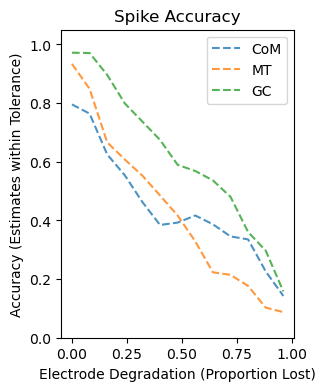

In [16]:
"""Figure 3A: Spike Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss = []
    for we_i, we in enumerate(wes_gt):

        if days[we_i] in fig_days:

            n_right = 0
            n_wrong = 0
            for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                dead_indices = dead_indices_coll[dead_indices_seed_i]
                tempgen = tempgen_coll[dead_indices_seed_i]
                recgen = recgen_coll[dead_indices_seed_i]
                loc_est_units = loc_est_units_coll[dead_indices_seed_i]
                time_units = time_units_coll[dead_indices_seed_i]
                loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
                time_spikes = time_spikes_coll[dead_indices_seed_i]
            
                unit_loc_est = loc_est_spikes[method][days[we_i]]
                
                # Calculate loss
                for unit_idx, unit_id in enumerate(we.unit_ids):
                    unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                    n_right += unit_n_right
                    n_wrong += unit_n_wrong

            loss.append(n_right / (n_right + n_wrong))

    # Create plot
    ax.plot(fig_days_label, loss, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3B_1.png', format='png', bbox_inches='tight')

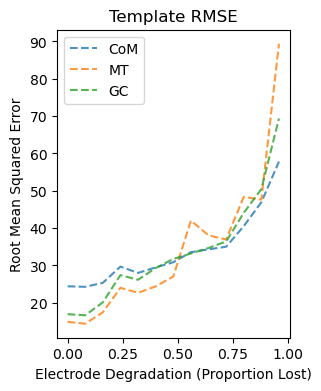

In [17]:
"""Figure 3A: Template RMSE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss = []
    for we_i, we in enumerate(wes_gt):

        if days[we_i] in fig_days:

            loss_day = 0
            for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                dead_indices = dead_indices_coll[dead_indices_seed_i]
                tempgen = tempgen_coll[dead_indices_seed_i]
                recgen = recgen_coll[dead_indices_seed_i]
                loc_est_units = loc_est_units_coll[dead_indices_seed_i]
                time_units = time_units_coll[dead_indices_seed_i]
                loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
                time_spikes = time_spikes_coll[dead_indices_seed_i]
                
                unit_loc_est = loc_est_units[method]
                loss_day += get_loss_rmse_gt(unit_loc_true, unit_loc_est[we_i])
            
            loss.append(loss_day / len(dead_indices_seeds))

    # Create plot
    loss = np.array(loss)
    ax.plot(fig_days_label, loss, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template RMSE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

fig.savefig(f'{output_mearec}/3A_2.png', format='png', bbox_inches='tight')

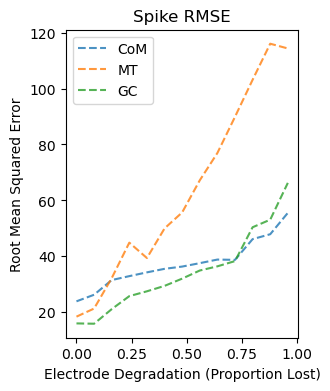

In [18]:
"""Figure 3B: Spike RMSE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss = []
    for we_i, we in enumerate(wes_gt):

        if days[we_i] in fig_days:

            day_SE = 0
            day_spikes = 0
            for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                dead_indices = dead_indices_coll[dead_indices_seed_i]
                tempgen = tempgen_coll[dead_indices_seed_i]
                recgen = recgen_coll[dead_indices_seed_i]
                loc_est_units = loc_est_units_coll[dead_indices_seed_i]
                time_units = time_units_coll[dead_indices_seed_i]
                loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
                time_spikes = time_spikes_coll[dead_indices_seed_i]
            
                unit_loc_est = loc_est_spikes[method][days[we_i]]
                
                # Calculate loss
                for unit_idx, unit_id in enumerate(we.unit_ids):                
                    unit_SE, unit_spikes = get_loss_RMSE_spikes_2(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
                    day_SE += unit_SE
                    day_spikes += unit_spikes
            
            loss.append(np.sqrt(day_SE/day_spikes))

    # Create plot
    ax.plot(fig_days_label, loss, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike RMSE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

fig.savefig(f'{output_mearec}/3B_2.png', format='png', bbox_inches='tight')

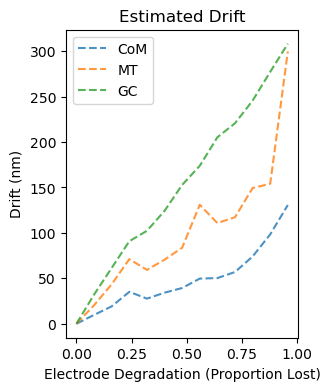

In [9]:
"""Figure 3A: Template Drift"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_drift = {}

for method in methods:
    estimated_drift[method] = np.zeros(len(fig_days))
    
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
        dead_indices = dead_indices_coll[dead_indices_seed_i]
        tempgen = tempgen_coll[dead_indices_seed_i]
        recgen = recgen_coll[dead_indices_seed_i]
        loc_est_units = loc_est_units_coll[dead_indices_seed_i]
        time_units = time_units_coll[dead_indices_seed_i]
        loc_est_spikes = loc_est_spikes_coll[dead_indices_seed_i]
        time_spikes = time_spikes_coll[dead_indices_seed_i]

        loc_est_unit_0 = loc_est_units[method][0]
        
        for we_i, we in enumerate(wes_gt):
            if days[we_i] in fig_days:
                loc_est_unit = loc_est_units[method][we_i]
                drift = np.mean(np.linalg.norm(loc_est_unit - loc_est_unit_0))
                day_index = fig_days.index(days[we_i])
                estimated_drift[method][day_index] += drift / len(dead_indices_seeds)
                        
# Create a line plot of the drift for all three localization methods
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_drift[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text('Estimated Drift')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Drift (nm)')
ax.legend()

fig.savefig(f'{output_mearec}/3A_3.png', format='png', bbox_inches='tight')

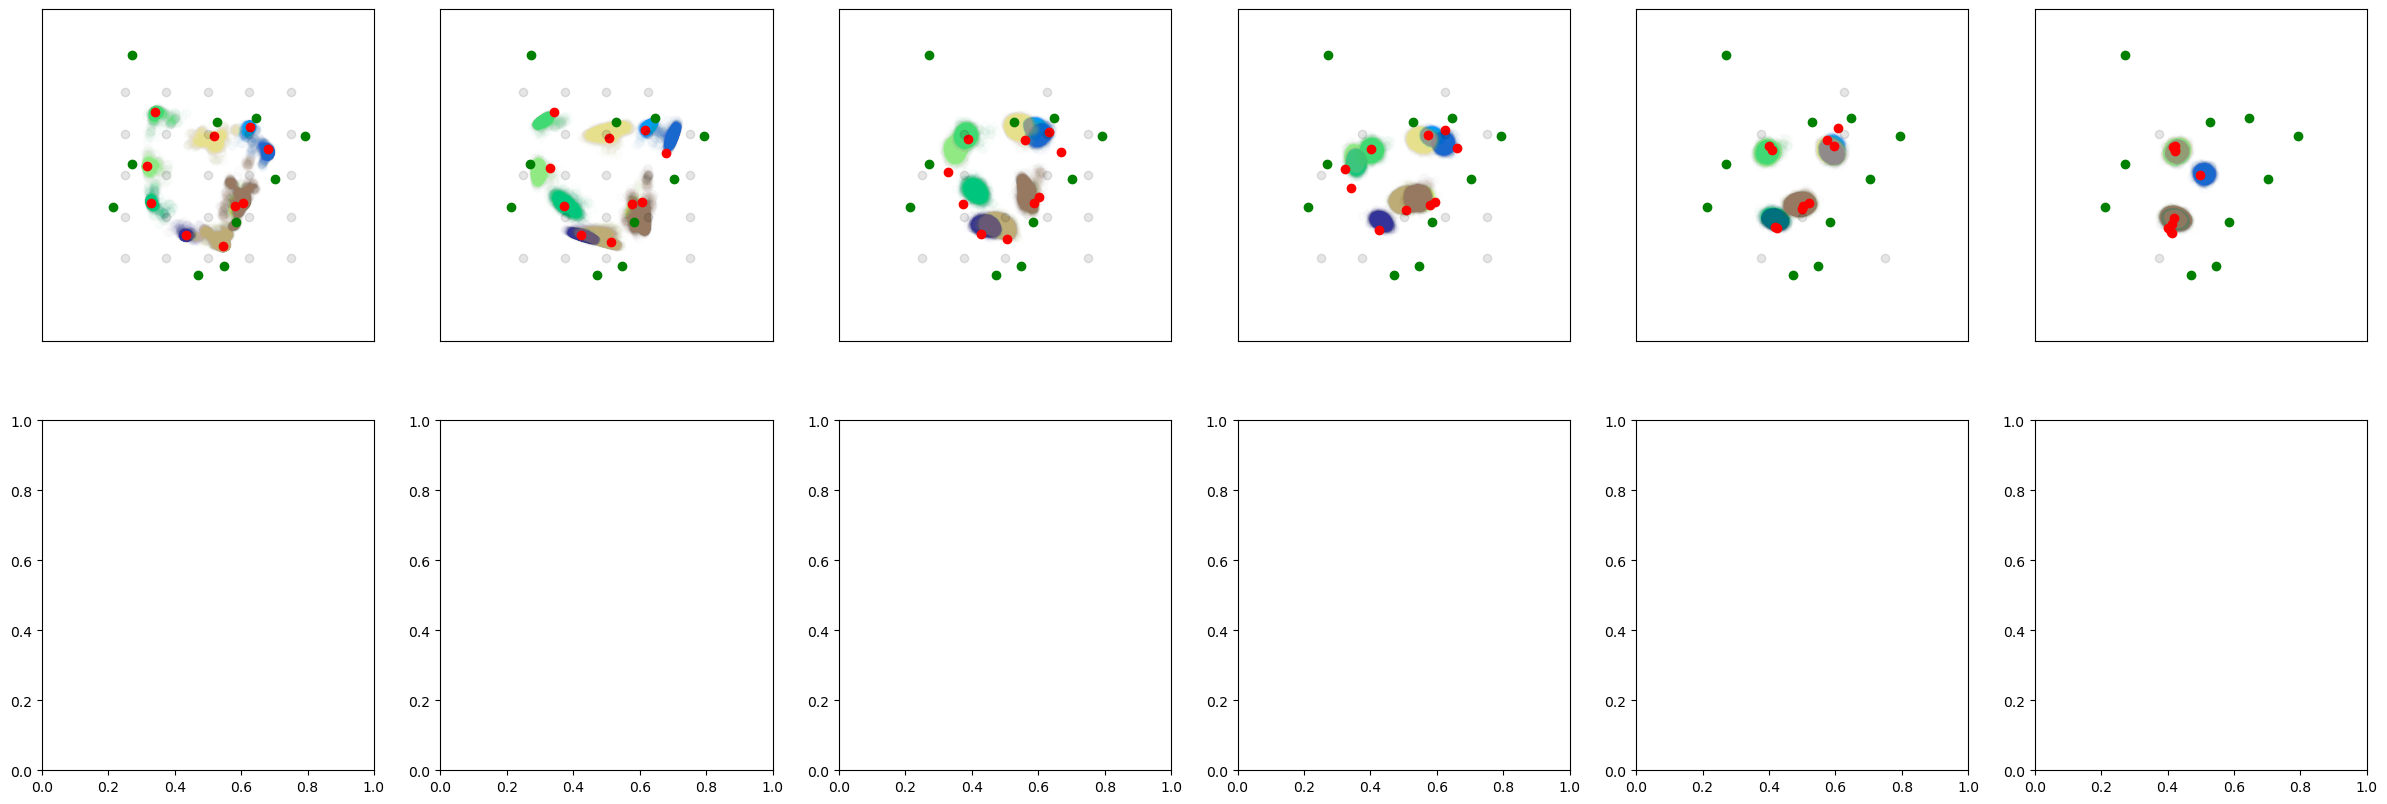

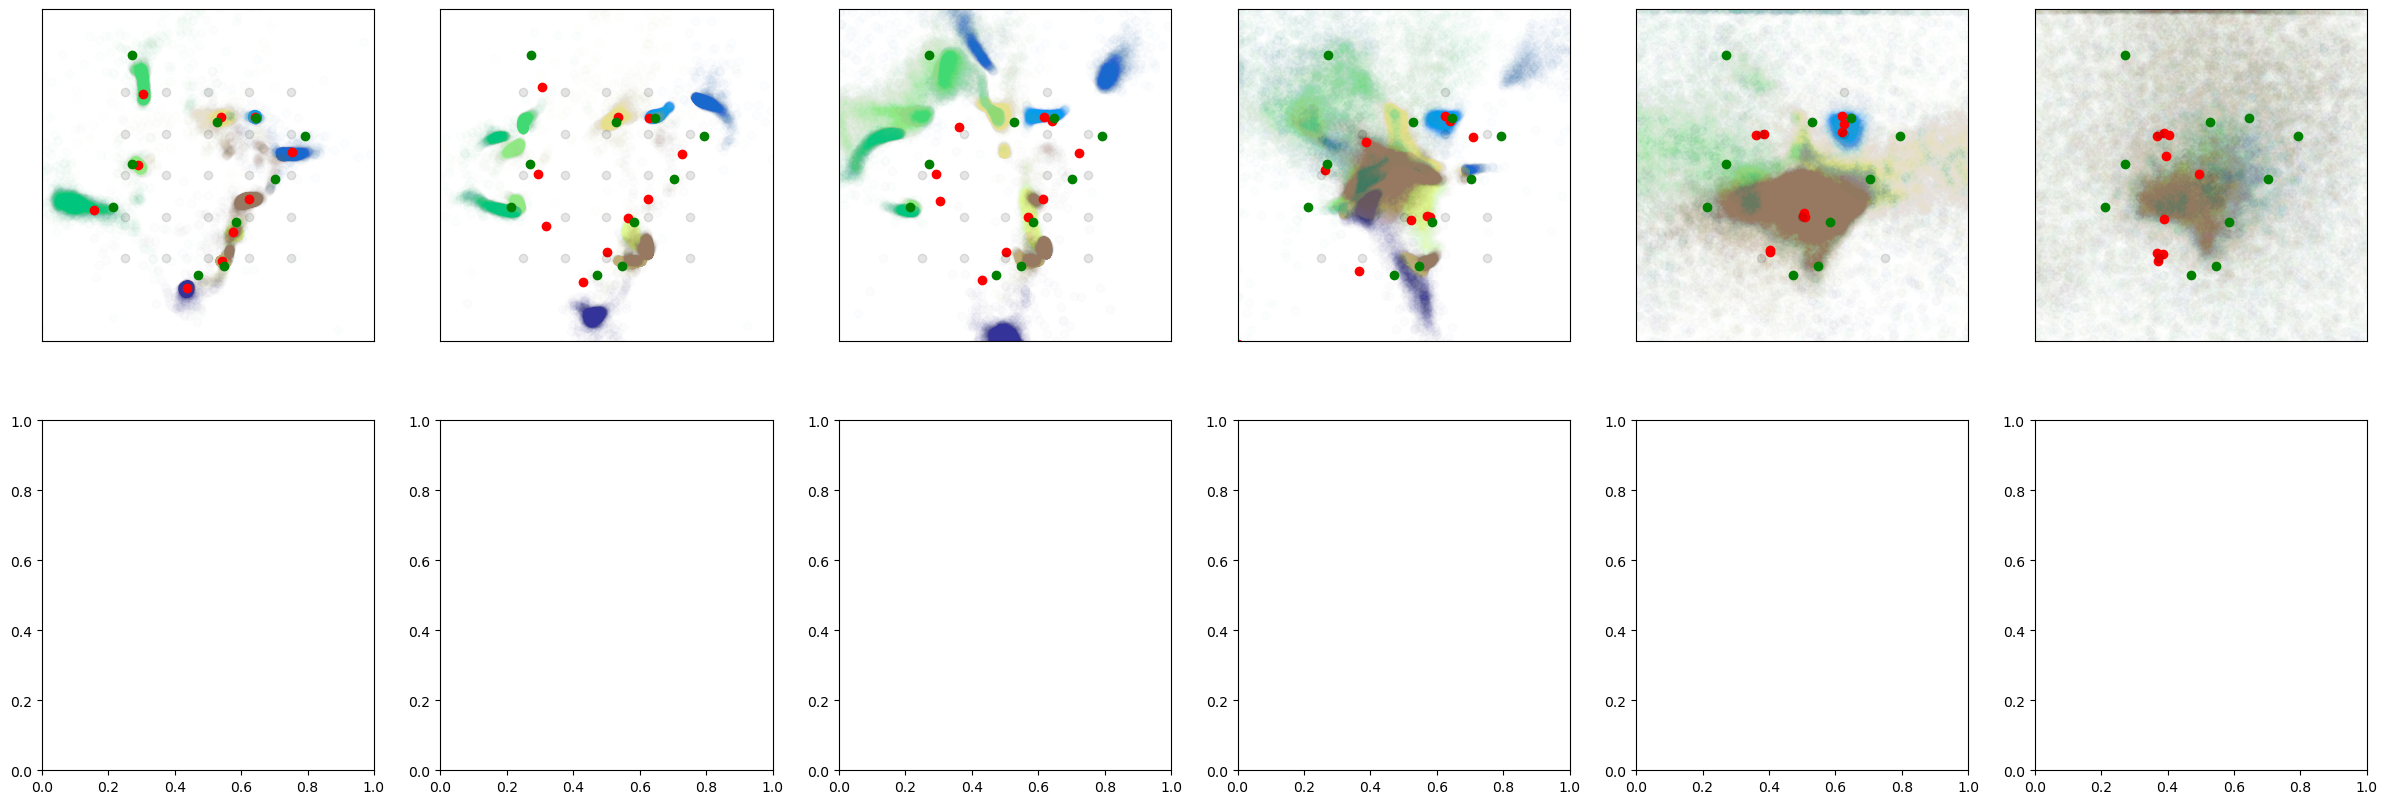

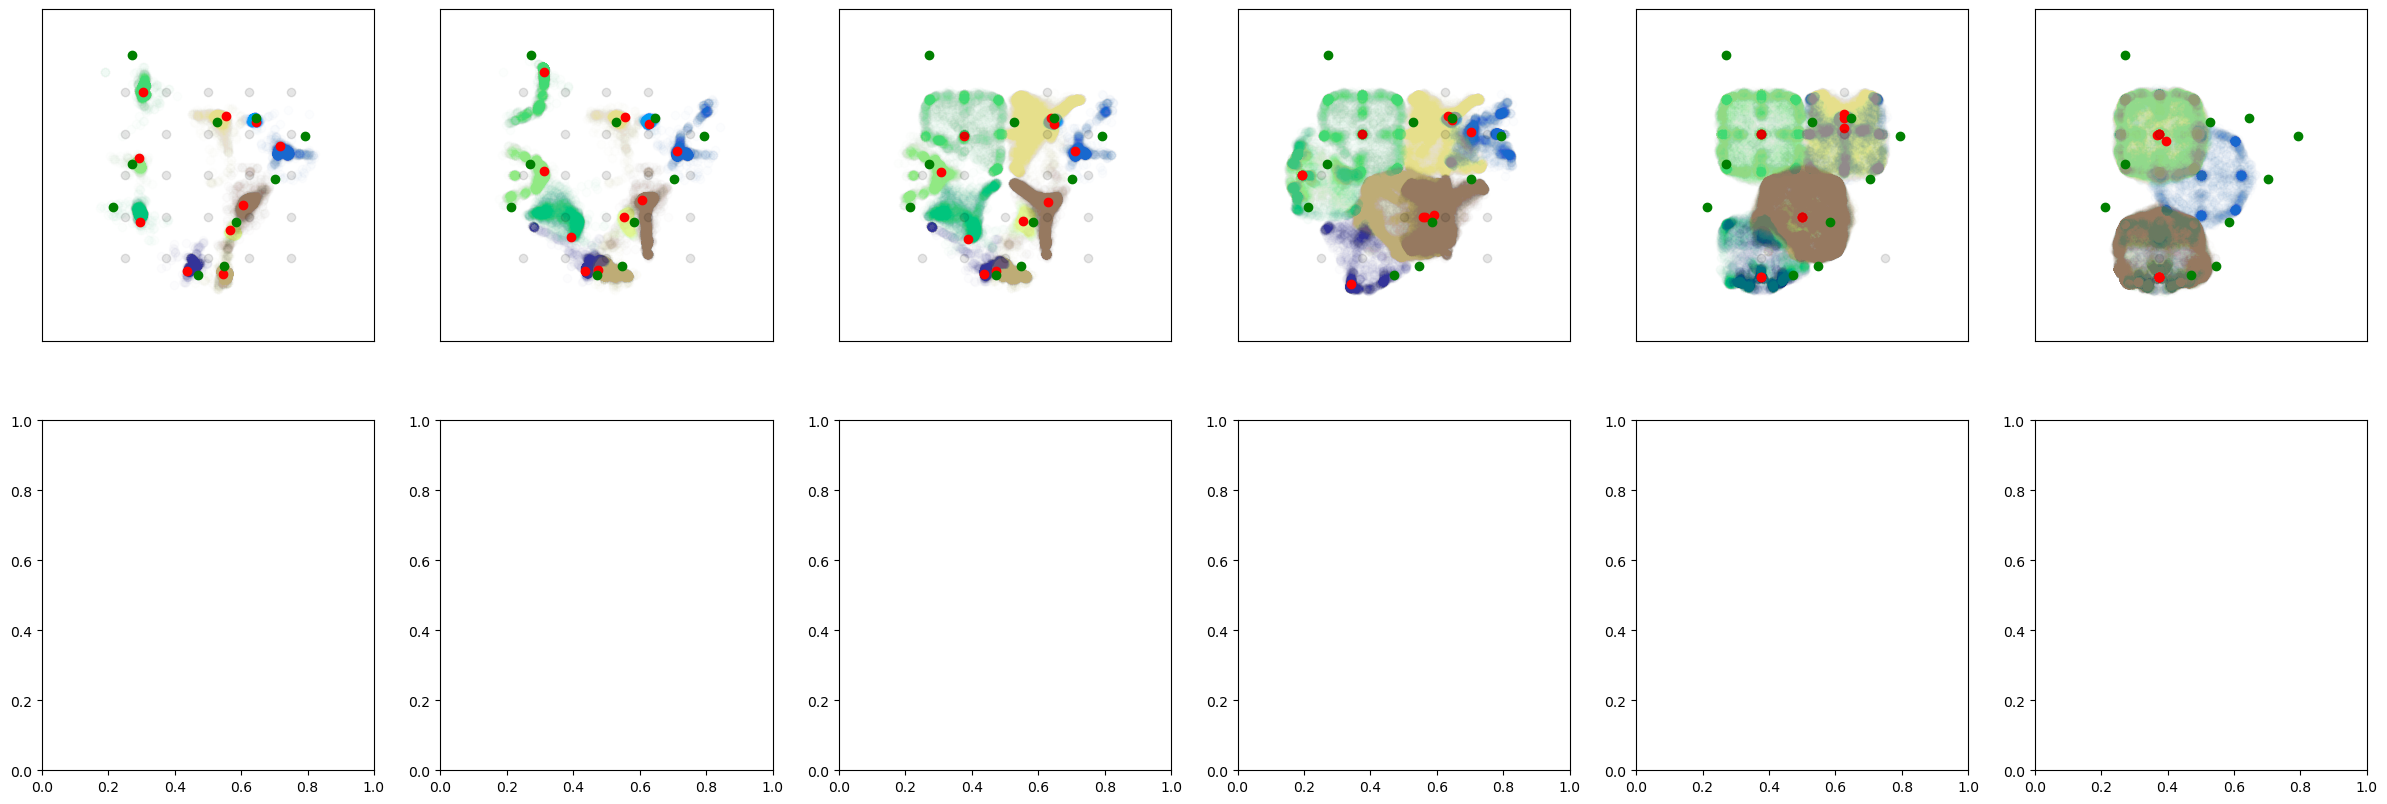

In [10]:
fig_days_2 = ['D0', 'D5', 'D10', 'D15', 'D20', 'D24']

for method in methods:

    range_x = electrode_loc[:, 0].max() - electrode_loc[:, 0].min()
    range_y = electrode_loc[:, 1].max() - electrode_loc[:, 1].min()
    range_A = min(range_x, range_y)

    col_num = 6
    row_num = max(int(np.ceil(len(fig_days_2)/col_num)),2)
    fig, axs = plt.subplots(row_num, col_num, figsize=(5*col_num, 5*row_num))  

    for we_i, we in enumerate(wes_gt):
        
        if days[we_i] in fig_days_2:

            loc_est_unit = loc_est_units[method][we_i]
            loc_est_spike = loc_est_spikes[method][days[we_i]]
            
            dead_electrodes = dead_indices[we_i]
            live_electrodes = np.delete(np.arange(electrode_loc.shape[0]), dead_electrodes)

            # Create plot
            row_gt = np.where(np.array(fig_days_2) == days[we_i])[0][0] // col_num
            col_gt = np.where(np.array(fig_days_2) == days[we_i])[0][0] % col_num

            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_loc_est_temp = loc_est_spike[0][unit_id]
                unit_loc_est_temp = np.array(unit_loc_est_temp.tolist())
                axs[row_gt, col_gt].scatter(unit_loc_est_temp[:, 0], unit_loc_est_temp[:, 1], color=plt.get_cmap('terrain')(unit_idx*20), alpha=0.01, label='Estimated Spikes', rasterized=True)

            axs[row_gt, col_gt].scatter(loc_est_unit[:, 0], loc_est_unit[:, 1], color='red', label='Estimated Templates')
            axs[row_gt, col_gt].scatter(unit_loc_true[:, 1], unit_loc_true[:, 2], color='green', label='True Neurons')
            axs[row_gt, col_gt].scatter(electrode_loc[live_electrodes, 0], electrode_loc[live_electrodes, 1], color=[0, 0, 0], alpha=0.1 , label='Electrodes')
            axs[row_gt, col_gt].set_xlim([electrode_loc[:, 0].min() - range_A*0.5, electrode_loc[:, 0].max() + range_A*0.5])
            axs[row_gt, col_gt].set_ylim([electrode_loc[:, 1].min() - range_A*0.5, electrode_loc[:, 1].max() + range_A*0.5])
            axs[row_gt, col_gt].get_xaxis().set_visible(False)
            axs[row_gt, col_gt].get_yaxis().set_visible(False)
            axs[row_gt, col_gt].set_aspect('equal')
    
    fig.savefig(f'{output_mearec}/3C_{method}.svg', format='svg', bbox_inches='tight', dpi=100)


# Re-import libraries

In [31]:
import importlib
import src

importlib.reload(src.util_eval)
from src.util_eval import *